[View in Colaboratory](https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb)

# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [1]:
# Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

from six.moves import cPickle as pickle
from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)


## Load Dataset

In [3]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 5)
Validation set (6000, 64, 64) (6000, 5)
Test set (13068, 64, 64) (13068, 5)


Label for image: [ 7  5 10 10 10]


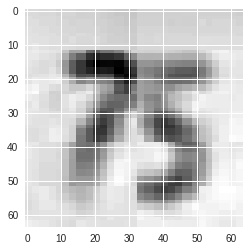

In [4]:
plt.figure()
plt.imshow(train_dataset[50], cmap='gray')

print("Label for image: {}".format(train_labels[50]))

## Convert Labels
This function converts each digit label to one-hot array.

In [0]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [0]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [7]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [0]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data


In [0]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [10]:
np.shape(train_images)

(27401, 64, 64, 1)

In [11]:
np.shape(test_images)

(13068, 64, 64, 1)

In [0]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


## Build Model
Build Deep Learning model to process data.

In [14]:
# Building the model

batch_size = 32
nb_classes = 11
nb_epoch = 24

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
print (model.summary())


# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 32)   288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 64, 64, 32)   128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 64, 64, 32)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_10 

 9472/27401 [=========>....................] - ETA: 1:00 - loss: 5.9564 - dense_8_loss: 2.0394 - dense_9_loss: 2.3436 - dense_10_loss: 1.2606 - dense_11_loss: 0.2941 - dense_12_loss: 0.0186 - dense_8_acc: 0.3197 - dense_9_acc: 0.2222 - dense_10_acc: 0.6914 - dense_11_acc: 0.9553 - dense_12_acc: 0.9966

18624/27401 [===================>..........] - ETA: 28s - loss: 4.9268 - dense_8_loss: 1.6248 - dense_9_loss: 1.9476 - dense_10_loss: 1.0896 - dense_11_loss: 0.2545 - dense_12_loss: 0.0104 - dense_8_acc: 0.4613 - dense_9_acc: 0.3479 - dense_10_acc: 0.7050 - dense_11_acc: 0.9560 - dense_12_acc: 0.9982

27328/27401 [============================>.] - ETA: 0s - loss: 4.2829 - dense_8_loss: 1.3844 - dense_9_loss: 1.6684 - dense_10_loss: 0.9869 - dense_11_loss: 0.2351 - dense_12_loss: 0.0082 - dense_8_acc: 0.5427 - dense_9_acc: 0.4436 - dense_10_acc: 0.7205 - dense_11_acc: 0.9556 - dense_12_acc: 0.9987

27401/27401 [==============================] - 93s 3ms/step - loss: 4.2780 - dense_8_loss: 1.3828 - dense_9_loss: 1.6665 - dense_10_loss: 0.9860 - dense_11_loss: 0.2345 - dense_12_loss: 0.0082 - dense_8_acc: 0.5432 - dense_9_acc: 0.4443 - dense_10_acc: 0.7208 - dense_11_acc: 0.9557 - dense_12_acc: 0.9987 - val_loss: 2.3898 - val_dense_8_loss: 0.6340 - val_dense_9_loss: 0.9174 - val_dense_10_loss: 0.6610 - val_dense_11_loss: 0.1695 - val_dense_12_loss: 0.0079 - val_dense_8_acc: 0.7897 - val_dense_9_acc: 0.7325 - val_dense_10_acc: 0.7958 - val_dense_11_acc: 0.9578 - val_dense_12_acc: 0.9993
Epoch 2/24
 3456/27401 [==>...........................] - ETA: 59s - loss: 2.4753 - dense_8_loss: 0.7454 - dense_9_loss: 0.9256 - dense_10_loss: 0.6544 - dense_11_loss: 0.1475 - dense_12_loss: 0.0024 - dense_8_acc: 0.7541 - dense_9_acc: 0.7011 - dense_10_acc: 0.7888 - dense_11_acc: 0.9612 - dense_12_acc: 0.9997

14048/27401 [==============>...............] - ETA: 33s - loss: 2.3013 - dense_8_loss: 0.6906 - dense_9_loss: 0.8303 - dense_10_loss: 0.6190 - dense_11_loss: 0.1599 - dense_12_loss: 0.0016 - dense_8_acc: 0.7781 - dense_9_acc: 0.7386 - dense_10_acc: 0.7980 - dense_11_acc: 0.9569 - dense_12_acc: 0.9999

24640/27401 [=========================>....] - ETA: 7s - loss: 2.1554 - dense_8_loss: 0.6471 - dense_9_loss: 0.7749 - dense_10_loss: 0.5740 - dense_11_loss: 0.1575 - dense_12_loss: 0.0019 - dense_8_acc: 0.7933 - dense_9_acc: 0.7575 - dense_10_acc: 0.8149 - dense_11_acc: 0.9576 - dense_12_acc: 0.9998

27401/27401 [==============================] - 76s 3ms/step - loss: 2.1233 - dense_8_loss: 0.6393 - dense_9_loss: 0.7615 - dense_10_loss: 0.5647 - dense_11_loss: 0.1558 - dense_12_loss: 0.0020 - dense_8_acc: 0.7964 - dense_9_acc: 0.7612 - dense_10_acc: 0.8183 - dense_11_acc: 0.9579 - dense_12_acc: 0.9998 - val_loss: 1.4285 - val_dense_8_loss: 0.4629 - val_dense_9_loss: 0.4877 - val_dense_10_loss: 0.3453 - val_dense_11_loss: 0.1243 - val_dense_12_loss: 0.0083 - val_dense_8_acc: 0.8510 - val_dense_9_acc: 0.8520 - val_dense_10_acc: 0.8968 - val_dense_11_acc: 0.9633 - val_dense_12_acc: 0.9993
Epoch 3/24
 2560/27401 [=>............................] - ETA: 1:00 - loss: 1.7382 - dense_8_loss: 0.5244 - dense_9_loss: 0.6069 - dense_10_loss: 0.4734 - dense_11_loss: 0.1330 - dense_12_loss: 4.8189e-04 - dense_8_acc: 0.8320 - dense_9_acc: 0.8156 - dense_10_acc: 0.8512 - dense_11_acc: 0.9625 - dense_12_acc: 1.0000

13120/27401 [=============>................] - ETA: 37s - loss: 1.6955 - dense_8_loss: 0.5072 - dense_9_loss: 0.6004 - dense_10_loss: 0.4465 - dense_11_loss: 0.1387 - dense_12_loss: 0.0027 - dense_8_acc: 0.8410 - dense_9_acc: 0.8185 - dense_10_acc: 0.8614 - dense_11_acc: 0.9611 - dense_12_acc: 0.9997

23712/27401 [========================>.....] - ETA: 9s - loss: 1.6379 - dense_8_loss: 0.4991 - dense_9_loss: 0.5763 - dense_10_loss: 0.4209 - dense_11_loss: 0.1400 - dense_12_loss: 0.0017 - dense_8_acc: 0.8448 - dense_9_acc: 0.8250 - dense_10_acc: 0.8711 - dense_11_acc: 0.9606 - dense_12_acc: 0.9998

27401/27401 [==============================] - 76s 3ms/step - loss: 1.6314 - dense_8_loss: 0.4974 - dense_9_loss: 0.5739 - dense_10_loss: 0.4209 - dense_11_loss: 0.1371 - dense_12_loss: 0.0020 - dense_8_acc: 0.8449 - dense_9_acc: 0.8253 - dense_10_acc: 0.8711 - dense_11_acc: 0.9610 - dense_12_acc: 0.9998 - val_loss: 1.1627 - val_dense_8_loss: 0.3464 - val_dense_9_loss: 0.4033 - val_dense_10_loss: 0.2838 - val_dense_11_loss: 0.1200 - val_dense_12_loss: 0.0092 - val_dense_8_acc: 0.8897 - val_dense_9_acc: 0.8767 - val_dense_10_acc: 0.9198 - val_dense_11_acc: 0.9650 - val_dense_12_acc: 0.9993
Epoch 4/24
 2240/27401 [=>............................] - ETA: 1:03 - loss: 1.4503 - dense_8_loss: 0.4093 - dense_9_loss: 0.5303 - dense_10_loss: 0.3909 - dense_11_loss: 0.1196 - dense_12_loss: 1.7480e-04 - dense_8_acc: 0.8705 - dense_9_acc: 0.8375 - dense_10_acc: 0.8754 - dense_11_acc: 0.9612 - dense_12_acc: 1.0000

12768/27401 [============>.................] - ETA: 38s - loss: 1.4563 - dense_8_loss: 0.4377 - dense_9_loss: 0.5116 - dense_10_loss: 0.3757 - dense_11_loss: 0.1299 - dense_12_loss: 0.0015 - dense_8_acc: 0.8638 - dense_9_acc: 0.8432 - dense_10_acc: 0.8867 - dense_11_acc: 0.9612 - dense_12_acc: 0.9998

23360/27401 [========================>.....] - ETA: 10s - loss: 1.4114 - dense_8_loss: 0.4290 - dense_9_loss: 0.4965 - dense_10_loss: 0.3561 - dense_11_loss: 0.1282 - dense_12_loss: 0.0016 - dense_8_acc: 0.8686 - dense_9_acc: 0.8473 - dense_10_acc: 0.8923 - dense_11_acc: 0.9624 - dense_12_acc: 0.9998

27401/27401 [==============================] - 77s 3ms/step - loss: 1.3942 - dense_8_loss: 0.4227 - dense_9_loss: 0.4906 - dense_10_loss: 0.3503 - dense_11_loss: 0.1289 - dense_12_loss: 0.0018 - dense_8_acc: 0.8706 - dense_9_acc: 0.8497 - dense_10_acc: 0.8947 - dense_11_acc: 0.9627 - dense_12_acc: 0.9998 - val_loss: 1.1649 - val_dense_8_loss: 0.3209 - val_dense_9_loss: 0.3862 - val_dense_10_loss: 0.3089 - val_dense_11_loss: 0.1419 - val_dense_12_loss: 0.0070 - val_dense_8_acc: 0.9003 - val_dense_9_acc: 0.8892 - val_dense_10_acc: 0.9120 - val_dense_11_acc: 0.9628 - val_dense_12_acc: 0.9993
Epoch 5/24
 2144/27401 [=>............................] - ETA: 1:02 - loss: 1.3161 - dense_8_loss: 0.3872 - dense_9_loss: 0.4635 - dense_10_loss: 0.3457 - dense_11_loss: 0.1148 - dense_12_loss: 0.0049 - dense_8_acc: 0.8792 - dense_9_acc: 0.8657 - dense_10_acc: 0.8899 - dense_11_acc: 0.9683 - dense_12_acc: 0.9991

12736/27401 [============>.................] - ETA: 37s - loss: 1.2546 - dense_8_loss: 0.3885 - dense_9_loss: 0.4404 - dense_10_loss: 0.3073 - dense_11_loss: 0.1170 - dense_12_loss: 0.0014 - dense_8_acc: 0.8828 - dense_9_acc: 0.8672 - dense_10_acc: 0.9085 - dense_11_acc: 0.9662 - dense_12_acc: 0.9998

23328/27401 [========================>.....] - ETA: 10s - loss: 1.2273 - dense_8_loss: 0.3823 - dense_9_loss: 0.4272 - dense_10_loss: 0.3042 - dense_11_loss: 0.1120 - dense_12_loss: 0.0016 - dense_8_acc: 0.8839 - dense_9_acc: 0.8717 - dense_10_acc: 0.9104 - dense_11_acc: 0.9672 - dense_12_acc: 0.9998

27401/27401 [==============================] - 76s 3ms/step - loss: 1.2224 - dense_8_loss: 0.3796 - dense_9_loss: 0.4229 - dense_10_loss: 0.3031 - dense_11_loss: 0.1154 - dense_12_loss: 0.0014 - dense_8_acc: 0.8853 - dense_9_acc: 0.8727 - dense_10_acc: 0.9110 - dense_11_acc: 0.9660 - dense_12_acc: 0.9998 - val_loss: 1.0037 - val_dense_8_loss: 0.3161 - val_dense_9_loss: 0.3287 - val_dense_10_loss: 0.2448 - val_dense_11_loss: 0.1055 - val_dense_12_loss: 0.0086 - val_dense_8_acc: 0.9002 - val_dense_9_acc: 0.9080 - val_dense_10_acc: 0.9317 - val_dense_11_acc: 0.9698 - val_dense_12_acc: 0.9993
Epoch 6/24
 2112/27401 [=>............................] - ETA: 1:02 - loss: 1.1222 - dense_8_loss: 0.3597 - dense_9_loss: 0.3825 - dense_10_loss: 0.2711 - dense_11_loss: 0.1088 - dense_12_loss: 1.3574e-04 - dense_8_acc: 0.8887 - dense_9_acc: 0.8802 - dense_10_acc: 0.9134 - dense_11_acc: 0.9650 - dense_12_acc: 1.0000

12544/27401 [============>.................] - ETA: 39s - loss: 1.0898 - dense_8_loss: 0.3425 - dense_9_loss: 0.3857 - dense_10_loss: 0.2617 - dense_11_loss: 0.0992 - dense_12_loss: 7.5043e-04 - dense_8_acc: 0.8965 - dense_9_acc: 0.8809 - dense_10_acc: 0.9220 - dense_11_acc: 0.9688 - dense_12_acc: 0.9999

23072/27401 [========================>.....] - ETA: 11s - loss: 1.0937 - dense_8_loss: 0.3401 - dense_9_loss: 0.3854 - dense_10_loss: 0.2639 - dense_11_loss: 0.1025 - dense_12_loss: 0.0018 - dense_8_acc: 0.8981 - dense_9_acc: 0.8835 - dense_10_acc: 0.9207 - dense_11_acc: 0.9691 - dense_12_acc: 0.9998

27401/27401 [==============================] - 77s 3ms/step - loss: 1.0985 - dense_8_loss: 0.3443 - dense_9_loss: 0.3844 - dense_10_loss: 0.2646 - dense_11_loss: 0.1036 - dense_12_loss: 0.0018 - dense_8_acc: 0.8973 - dense_9_acc: 0.8848 - dense_10_acc: 0.9210 - dense_11_acc: 0.9692 - dense_12_acc: 0.9998 - val_loss: 0.9525 - val_dense_8_loss: 0.2898 - val_dense_9_loss: 0.3253 - val_dense_10_loss: 0.2275 - val_dense_11_loss: 0.1020 - val_dense_12_loss: 0.0080 - val_dense_8_acc: 0.9112 - val_dense_9_acc: 0.9070 - val_dense_10_acc: 0.9350 - val_dense_11_acc: 0.9707 - val_dense_12_acc: 0.9993
Epoch 7/24
 2048/27401 [=>............................] - ETA: 1:03 - loss: 0.9696 - dense_8_loss: 0.3008 - dense_9_loss: 0.3227 - dense_10_loss: 0.2362 - dense_11_loss: 0.1052 - dense_12_loss: 0.0046 - dense_8_acc: 0.9028 - dense_9_acc: 0.8999 - dense_10_acc: 0.9287 - dense_11_acc: 0.9658 - dense_12_acc: 0.9990

12640/27401 [============>.................] - ETA: 38s - loss: 0.9872 - dense_8_loss: 0.3140 - dense_9_loss: 0.3399 - dense_10_loss: 0.2394 - dense_11_loss: 0.0915 - dense_12_loss: 0.0025 - dense_8_acc: 0.9050 - dense_9_acc: 0.8967 - dense_10_acc: 0.9272 - dense_11_acc: 0.9719 - dense_12_acc: 0.9997

23232/27401 [========================>.....] - ETA: 11s - loss: 0.9940 - dense_8_loss: 0.3155 - dense_9_loss: 0.3446 - dense_10_loss: 0.2407 - dense_11_loss: 0.0918 - dense_12_loss: 0.0014 - dense_8_acc: 0.9039 - dense_9_acc: 0.8962 - dense_10_acc: 0.9270 - dense_11_acc: 0.9724 - dense_12_acc: 0.9998

27401/27401 [==============================] - 77s 3ms/step - loss: 0.9860 - dense_8_loss: 0.3128 - dense_9_loss: 0.3422 - dense_10_loss: 0.2389 - dense_11_loss: 0.0905 - dense_12_loss: 0.0016 - dense_8_acc: 0.9052 - dense_9_acc: 0.8966 - dense_10_acc: 0.9279 - dense_11_acc: 0.9727 - dense_12_acc: 0.9998 - val_loss: 0.8401 - val_dense_8_loss: 0.2548 - val_dense_9_loss: 0.2839 - val_dense_10_loss: 0.2061 - val_dense_11_loss: 0.0868 - val_dense_12_loss: 0.0086 - val_dense_8_acc: 0.9213 - val_dense_9_acc: 0.9205 - val_dense_10_acc: 0.9442 - val_dense_11_acc: 0.9768 - val_dense_12_acc: 0.9993
Epoch 8/24
 2080/27401 [=>............................] - ETA: 1:02 - loss: 0.8995 - dense_8_loss: 0.2847 - dense_9_loss: 0.3181 - dense_10_loss: 0.2158 - dense_11_loss: 0.0808 - dense_12_loss: 1.6200e-04 - dense_8_acc: 0.9087 - dense_9_acc: 0.9048 - dense_10_acc: 0.9365 - dense_11_acc: 0.9740 - dense_12_acc: 1.0000

12512/27401 [============>.................] - ETA: 39s - loss: 0.9057 - dense_8_loss: 0.3029 - dense_9_loss: 0.3071 - dense_10_loss: 0.2179 - dense_11_loss: 0.0771 - dense_12_loss: 8.2349e-04 - dense_8_acc: 0.9086 - dense_9_acc: 0.9082 - dense_10_acc: 0.9354 - dense_11_acc: 0.9763 - dense_12_acc: 0.9999

23040/27401 [========================>.....] - ETA: 11s - loss: 0.9149 - dense_8_loss: 0.2988 - dense_9_loss: 0.3146 - dense_10_loss: 0.2200 - dense_11_loss: 0.0797 - dense_12_loss: 0.0018 - dense_8_acc: 0.9085 - dense_9_acc: 0.9059 - dense_10_acc: 0.9345 - dense_11_acc: 0.9763 - dense_12_acc: 0.9998

27401/27401 [==============================] - 78s 3ms/step - loss: 0.9195 - dense_8_loss: 0.2982 - dense_9_loss: 0.3172 - dense_10_loss: 0.2229 - dense_11_loss: 0.0796 - dense_12_loss: 0.0015 - dense_8_acc: 0.9098 - dense_9_acc: 0.9057 - dense_10_acc: 0.9342 - dense_11_acc: 0.9764 - dense_12_acc: 0.9998 - val_loss: 0.8626 - val_dense_8_loss: 0.2623 - val_dense_9_loss: 0.2970 - val_dense_10_loss: 0.2152 - val_dense_11_loss: 0.0786 - val_dense_12_loss: 0.0094 - val_dense_8_acc: 0.9222 - val_dense_9_acc: 0.9135 - val_dense_10_acc: 0.9405 - val_dense_11_acc: 0.9808 - val_dense_12_acc: 0.9993
Epoch 9/24
 2048/27401 [=>............................] - ETA: 1:03 - loss: 0.8543 - dense_8_loss: 0.2682 - dense_9_loss: 0.3097 - dense_10_loss: 0.2048 - dense_11_loss: 0.0693 - dense_12_loss: 0.0023 - dense_8_acc: 0.9180 - dense_9_acc: 0.9072 - dense_10_acc: 0.9429 - dense_11_acc: 0.9819 - dense_12_acc: 0.9995

12608/27401 [============>.................] - ETA: 39s - loss: 0.8101 - dense_8_loss: 0.2657 - dense_9_loss: 0.2835 - dense_10_loss: 0.1881 - dense_11_loss: 0.0713 - dense_12_loss: 0.0015 - dense_8_acc: 0.9212 - dense_9_acc: 0.9134 - dense_10_acc: 0.9446 - dense_11_acc: 0.9786 - dense_12_acc: 0.9997

23136/27401 [========================>.....] - ETA: 11s - loss: 0.8206 - dense_8_loss: 0.2660 - dense_9_loss: 0.2930 - dense_10_loss: 0.1924 - dense_11_loss: 0.0684 - dense_12_loss: 9.5079e-04 - dense_8_acc: 0.9193 - dense_9_acc: 0.9121 - dense_10_acc: 0.9430 - dense_11_acc: 0.9794 - dense_12_acc: 0.9998

27401/27401 [==============================] - 78s 3ms/step - loss: 0.8301 - dense_8_loss: 0.2668 - dense_9_loss: 0.2956 - dense_10_loss: 0.1972 - dense_11_loss: 0.0698 - dense_12_loss: 8.1320e-04 - dense_8_acc: 0.9188 - dense_9_acc: 0.9115 - dense_10_acc: 0.9415 - dense_11_acc: 0.9789 - dense_12_acc: 0.9998 - val_loss: 0.8097 - val_dense_8_loss: 0.2481 - val_dense_9_loss: 0.2927 - val_dense_10_loss: 0.1861 - val_dense_11_loss: 0.0739 - val_dense_12_loss: 0.0089 - val_dense_8_acc: 0.9297 - val_dense_9_acc: 0.9203 - val_dense_10_acc: 0.9490 - val_dense_11_acc: 0.9793 - val_dense_12_acc: 0.9993
Epoch 10/24
 2016/27401 [=>............................] - ETA: 1:04 - loss: 0.7790 - dense_8_loss: 0.2499 - dense_9_loss: 0.2837 - dense_10_loss: 0.1855 - dense_11_loss: 0.0598 - dense_12_loss: 5.9157e-05 - dense_8_acc: 0.9286 - dense_9_acc: 0.9102 - dense_10_acc: 0.9395 - dense_11_acc: 0.9836 - dense_12_acc: 1.0000

12480/27401 [============>.................] - ETA: 39s - loss: 0.7372 - dense_8_loss: 0.2316 - dense_9_loss: 0.2729 - dense_10_loss: 0.1697 - dense_11_loss: 0.0609 - dense_12_loss: 0.0021 - dense_8_acc: 0.9300 - dense_9_acc: 0.9191 - dense_10_acc: 0.9484 - dense_11_acc: 0.9815 - dense_12_acc: 0.9998

23072/27401 [========================>.....] - ETA: 11s - loss: 0.7553 - dense_8_loss: 0.2450 - dense_9_loss: 0.2717 - dense_10_loss: 0.1758 - dense_11_loss: 0.0614 - dense_12_loss: 0.0014 - dense_8_acc: 0.9255 - dense_9_acc: 0.9186 - dense_10_acc: 0.9455 - dense_11_acc: 0.9807 - dense_12_acc: 0.9998

27401/27401 [==============================] - 78s 3ms/step - loss: 0.7644 - dense_8_loss: 0.2460 - dense_9_loss: 0.2742 - dense_10_loss: 0.1818 - dense_11_loss: 0.0611 - dense_12_loss: 0.0014 - dense_8_acc: 0.9260 - dense_9_acc: 0.9181 - dense_10_acc: 0.9447 - dense_11_acc: 0.9809 - dense_12_acc: 0.9998 - val_loss: 0.8073 - val_dense_8_loss: 0.2501 - val_dense_9_loss: 0.2889 - val_dense_10_loss: 0.1895 - val_dense_11_loss: 0.0704 - val_dense_12_loss: 0.0084 - val_dense_8_acc: 0.9305 - val_dense_9_acc: 0.9208 - val_dense_10_acc: 0.9498 - val_dense_11_acc: 0.9822 - val_dense_12_acc: 0.9993
Epoch 11/24
 2048/27401 [=>............................] - ETA: 1:03 - loss: 0.6973 - dense_8_loss: 0.2305 - dense_9_loss: 0.2427 - dense_10_loss: 0.1696 - dense_11_loss: 0.0537 - dense_12_loss: 8.9709e-04 - dense_8_acc: 0.9229 - dense_9_acc: 0.9282 - dense_10_acc: 0.9482 - dense_11_acc: 0.9839 - dense_12_acc: 0.9995

12544/27401 [============>.................] - ETA: 39s - loss: 0.6878 - dense_8_loss: 0.2328 - dense_9_loss: 0.2401 - dense_10_loss: 0.1589 - dense_11_loss: 0.0550 - dense_12_loss: 9.6324e-04 - dense_8_acc: 0.9287 - dense_9_acc: 0.9285 - dense_10_acc: 0.9516 - dense_11_acc: 0.9833 - dense_12_acc: 0.9998

23104/27401 [========================>.....] - ETA: 11s - loss: 0.7090 - dense_8_loss: 0.2357 - dense_9_loss: 0.2501 - dense_10_loss: 0.1646 - dense_11_loss: 0.0574 - dense_12_loss: 0.0012 - dense_8_acc: 0.9294 - dense_9_acc: 0.9255 - dense_10_acc: 0.9507 - dense_11_acc: 0.9822 - dense_12_acc: 0.9998

27401/27401 [==============================] - 78s 3ms/step - loss: 0.7088 - dense_8_loss: 0.2335 - dense_9_loss: 0.2519 - dense_10_loss: 0.1634 - dense_11_loss: 0.0590 - dense_12_loss: 0.0010 - dense_8_acc: 0.9301 - dense_9_acc: 0.9257 - dense_10_acc: 0.9510 - dense_11_acc: 0.9819 - dense_12_acc: 0.9998 - val_loss: 0.7704 - val_dense_8_loss: 0.2317 - val_dense_9_loss: 0.2781 - val_dense_10_loss: 0.1877 - val_dense_11_loss: 0.0633 - val_dense_12_loss: 0.0095 - val_dense_8_acc: 0.9348 - val_dense_9_acc: 0.9262 - val_dense_10_acc: 0.9527 - val_dense_11_acc: 0.9828 - val_dense_12_acc: 0.9993
Epoch 12/24
 2048/27401 [=>............................] - ETA: 1:03 - loss: 0.5827 - dense_8_loss: 0.1870 - dense_9_loss: 0.2020 - dense_10_loss: 0.1487 - dense_11_loss: 0.0420 - dense_12_loss: 0.0030 - dense_8_acc: 0.9438 - dense_9_acc: 0.9399 - dense_10_acc: 0.9590 - dense_11_acc: 0.9854 - dense_12_acc: 0.9995

12640/27401 [============>.................] - ETA: 39s - loss: 0.6552 - dense_8_loss: 0.2183 - dense_9_loss: 0.2293 - dense_10_loss: 0.1573 - dense_11_loss: 0.0487 - dense_12_loss: 0.0017 - dense_8_acc: 0.9373 - dense_9_acc: 0.9320 - dense_10_acc: 0.9547 - dense_11_acc: 0.9843 - dense_12_acc: 0.9996

23200/27401 [========================>.....] - ETA: 11s - loss: 0.6522 - dense_8_loss: 0.2171 - dense_9_loss: 0.2308 - dense_10_loss: 0.1546 - dense_11_loss: 0.0487 - dense_12_loss: 9.4671e-04 - dense_8_acc: 0.9345 - dense_9_acc: 0.9314 - dense_10_acc: 0.9547 - dense_11_acc: 0.9844 - dense_12_acc: 0.9998

27401/27401 [==============================] - 77s 3ms/step - loss: 0.6520 - dense_8_loss: 0.2176 - dense_9_loss: 0.2317 - dense_10_loss: 0.1528 - dense_11_loss: 0.0490 - dense_12_loss: 8.0908e-04 - dense_8_acc: 0.9344 - dense_9_acc: 0.9311 - dense_10_acc: 0.9547 - dense_11_acc: 0.9845 - dense_12_acc: 0.9998 - val_loss: 0.7784 - val_dense_8_loss: 0.2376 - val_dense_9_loss: 0.2875 - val_dense_10_loss: 0.1856 - val_dense_11_loss: 0.0589 - val_dense_12_loss: 0.0087 - val_dense_8_acc: 0.9342 - val_dense_9_acc: 0.9282 - val_dense_10_acc: 0.9537 - val_dense_11_acc: 0.9840 - val_dense_12_acc: 0.9993
Epoch 13/24
 2048/27401 [=>............................] - ETA: 1:03 - loss: 0.5512 - dense_8_loss: 0.1926 - dense_9_loss: 0.1967 - dense_10_loss: 0.1184 - dense_11_loss: 0.0421 - dense_12_loss: 0.0015 - dense_8_acc: 0.9331 - dense_9_acc: 0.9375 - dense_10_acc: 0.9634 - dense_11_acc: 0.9868 - dense_12_acc: 0.9995

12608/27401 [============>.................] - ETA: 39s - loss: 0.5889 - dense_8_loss: 0.2066 - dense_9_loss: 0.2070 - dense_10_loss: 0.1315 - dense_11_loss: 0.0423 - dense_12_loss: 0.0014 - dense_8_acc: 0.9356 - dense_9_acc: 0.9370 - dense_10_acc: 0.9585 - dense_11_acc: 0.9879 - dense_12_acc: 0.9996

23168/27401 [========================>.....] - ETA: 11s - loss: 0.6031 - dense_8_loss: 0.2032 - dense_9_loss: 0.2152 - dense_10_loss: 0.1398 - dense_11_loss: 0.0439 - dense_12_loss: 9.1773e-04 - dense_8_acc: 0.9368 - dense_9_acc: 0.9358 - dense_10_acc: 0.9567 - dense_11_acc: 0.9865 - dense_12_acc: 0.9997

27401/27401 [==============================] - 78s 3ms/step - loss: 0.6034 - dense_8_loss: 0.2034 - dense_9_loss: 0.2167 - dense_10_loss: 0.1387 - dense_11_loss: 0.0439 - dense_12_loss: 7.8667e-04 - dense_8_acc: 0.9367 - dense_9_acc: 0.9348 - dense_10_acc: 0.9577 - dense_11_acc: 0.9864 - dense_12_acc: 0.9997 - val_loss: 0.8008 - val_dense_8_loss: 0.2450 - val_dense_9_loss: 0.2894 - val_dense_10_loss: 0.1969 - val_dense_11_loss: 0.0604 - val_dense_12_loss: 0.0090 - val_dense_8_acc: 0.9330 - val_dense_9_acc: 0.9233 - val_dense_10_acc: 0.9503 - val_dense_11_acc: 0.9838 - val_dense_12_acc: 0.9993
Epoch 14/24
 2048/27401 [=>............................] - ETA: 1:04 - loss: 0.5657 - dense_8_loss: 0.2032 - dense_9_loss: 0.1951 - dense_10_loss: 0.1239 - dense_11_loss: 0.0434 - dense_12_loss: 4.0717e-05 - dense_8_acc: 0.9404 - dense_9_acc: 0.9399 - dense_10_acc: 0.9629 - dense_11_acc: 0.9863 - dense_12_acc: 1.0000

12544/27401 [============>.................] - ETA: 40s - loss: 0.5565 - dense_8_loss: 0.1843 - dense_9_loss: 0.2047 - dense_10_loss: 0.1242 - dense_11_loss: 0.0423 - dense_12_loss: 0.0011 - dense_8_acc: 0.9428 - dense_9_acc: 0.9359 - dense_10_acc: 0.9617 - dense_11_acc: 0.9876 - dense_12_acc: 0.9998

23008/27401 [========================>.....] - ETA: 11s - loss: 0.5671 - dense_8_loss: 0.1844 - dense_9_loss: 0.2081 - dense_10_loss: 0.1310 - dense_11_loss: 0.0428 - dense_12_loss: 7.6290e-04 - dense_8_acc: 0.9428 - dense_9_acc: 0.9362 - dense_10_acc: 0.9600 - dense_11_acc: 0.9872 - dense_12_acc: 0.9998

27401/27401 [==============================] - 79s 3ms/step - loss: 0.5754 - dense_8_loss: 0.1890 - dense_9_loss: 0.2105 - dense_10_loss: 0.1319 - dense_11_loss: 0.0432 - dense_12_loss: 8.3397e-04 - dense_8_acc: 0.9414 - dense_9_acc: 0.9357 - dense_10_acc: 0.9597 - dense_11_acc: 0.9872 - dense_12_acc: 0.9998 - val_loss: 0.7944 - val_dense_8_loss: 0.2443 - val_dense_9_loss: 0.2887 - val_dense_10_loss: 0.1933 - val_dense_11_loss: 0.0594 - val_dense_12_loss: 0.0088 - val_dense_8_acc: 0.9333 - val_dense_9_acc: 0.9265 - val_dense_10_acc: 0.9523 - val_dense_11_acc: 0.9852 - val_dense_12_acc: 0.9993
Epoch 15/24
 1984/27401 [=>............................] - ETA: 1:04 - loss: 0.4982 - dense_8_loss: 0.1887 - dense_9_loss: 0.1821 - dense_10_loss: 0.1037 - dense_11_loss: 0.0236 - dense_12_loss: 2.7867e-05 - dense_8_acc: 0.9375 - dense_9_acc: 0.9390 - dense_10_acc: 0.9647 - dense_11_acc: 0.9929 - dense_12_acc: 1.0000

12480/27401 [============>.................] - ETA: 39s - loss: 0.5047 - dense_8_loss: 0.1748 - dense_9_loss: 0.1772 - dense_10_loss: 0.1160 - dense_11_loss: 0.0354 - dense_12_loss: 0.0013 - dense_8_acc: 0.9441 - dense_9_acc: 0.9465 - dense_10_acc: 0.9631 - dense_11_acc: 0.9896 - dense_12_acc: 0.9998

22976/27401 [========================>.....] - ETA: 11s - loss: 0.5336 - dense_8_loss: 0.1828 - dense_9_loss: 0.1885 - dense_10_loss: 0.1234 - dense_11_loss: 0.0380 - dense_12_loss: 9.0448e-04 - dense_8_acc: 0.9421 - dense_9_acc: 0.9438 - dense_10_acc: 0.9617 - dense_11_acc: 0.9882 - dense_12_acc: 0.9998

27401/27401 [==============================] - 78s 3ms/step - loss: 0.5407 - dense_8_loss: 0.1819 - dense_9_loss: 0.1916 - dense_10_loss: 0.1266 - dense_11_loss: 0.0398 - dense_12_loss: 7.7077e-04 - dense_8_acc: 0.9426 - dense_9_acc: 0.9424 - dense_10_acc: 0.9609 - dense_11_acc: 0.9879 - dense_12_acc: 0.9998 - val_loss: 0.7781 - val_dense_8_loss: 0.2308 - val_dense_9_loss: 0.2809 - val_dense_10_loss: 0.1954 - val_dense_11_loss: 0.0619 - val_dense_12_loss: 0.0092 - val_dense_8_acc: 0.9375 - val_dense_9_acc: 0.9293 - val_dense_10_acc: 0.9528 - val_dense_11_acc: 0.9843 - val_dense_12_acc: 0.9993
Epoch 16/24
 1984/27401 [=>............................] - ETA: 1:04 - loss: 0.4318 - dense_8_loss: 0.1558 - dense_9_loss: 0.1365 - dense_10_loss: 0.1027 - dense_11_loss: 0.0368 - dense_12_loss: 3.7746e-05 - dense_8_acc: 0.9496 - dense_9_acc: 0.9587 - dense_10_acc: 0.9682 - dense_11_acc: 0.9889 - dense_12_acc: 1.0000

12448/27401 [============>.................] - ETA: 39s - loss: 0.4649 - dense_8_loss: 0.1540 - dense_9_loss: 0.1660 - dense_10_loss: 0.1092 - dense_11_loss: 0.0347 - dense_12_loss: 0.0010 - dense_8_acc: 0.9497 - dense_9_acc: 0.9490 - dense_10_acc: 0.9643 - dense_11_acc: 0.9899 - dense_12_acc: 0.9998

22880/27401 [========================>.....] - ETA: 12s - loss: 0.4950 - dense_8_loss: 0.1668 - dense_9_loss: 0.1766 - dense_10_loss: 0.1170 - dense_11_loss: 0.0339 - dense_12_loss: 7.2141e-04 - dense_8_acc: 0.9468 - dense_9_acc: 0.9451 - dense_10_acc: 0.9626 - dense_11_acc: 0.9896 - dense_12_acc: 0.9999

27401/27401 [==============================] - 77s 3ms/step - loss: 0.5062 - dense_8_loss: 0.1705 - dense_9_loss: 0.1807 - dense_10_loss: 0.1182 - dense_11_loss: 0.0360 - dense_12_loss: 6.6217e-04 - dense_8_acc: 0.9457 - dense_9_acc: 0.9435 - dense_10_acc: 0.9620 - dense_11_acc: 0.9890 - dense_12_acc: 0.9999 - val_loss: 0.7900 - val_dense_8_loss: 0.2513 - val_dense_9_loss: 0.2846 - val_dense_10_loss: 0.1894 - val_dense_11_loss: 0.0556 - val_dense_12_loss: 0.0092 - val_dense_8_acc: 0.9322 - val_dense_9_acc: 0.9290 - val_dense_10_acc: 0.9532 - val_dense_11_acc: 0.9863 - val_dense_12_acc: 0.9993


In [0]:
predictions = model.predict(test_images)

In [16]:
np.shape(predictions)

(5, 13068, 11)

In [17]:
len(predictions[0])

13068

In [32]:
np.shape(test_labels)
print(predictions[2][20])
print(np.argmax(predictions[2][20]))

[1.15817154e-10 8.73155670e-07 1.46495645e-11 4.47277557e-08
 9.15053100e-09 9.84799868e-08 5.33395134e-11 2.07697637e-09
 9.61354538e-11 1.97324879e-10 9.99998927e-01]
10


## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [0]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    coverage_counter = 0
    confidence = 0.7
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
            if predictions[j][i][np.argmax(predictions[j][i])] >= confidence:
                coverage_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter / float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter / float(len(predictions[0]))
    coverage = coverage_counter / float(len(predictions[0]) * 5)
    
    return ind_accuracy,global_accuracy, coverage

In [0]:
ind_acc, glob_acc, coverage = calculate_acc(predictions, test_labels)

In [49]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))
print("The coverage is {} %".format(coverage * 100))

The individual accuracy is 96.7217630854 %
The sequence prediction accuracy is 87.3125191307 %
The coverage is 96.4631160086 %


Actual labels: [2, 7, 2, 10, 10]
Predicted labels: [2, 2, 10, 10, 10]

Actual labels: [4, 5, 10, 10, 10]
Predicted labels: [4, 5, 10, 10, 10]

Actual labels: [6, 2, 10, 10, 10]
Predicted labels: [6, 2, 10, 10, 10]

Actual labels: [4, 8, 10, 10, 10]
Predicted labels: [4, 8, 10, 10, 10]

Actual labels: [2, 1, 6, 10, 10]
Predicted labels: [2, 1, 6, 10, 10]



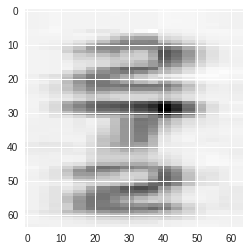

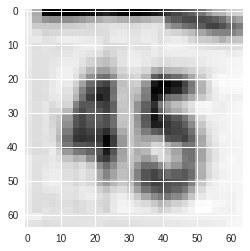

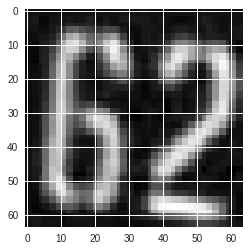

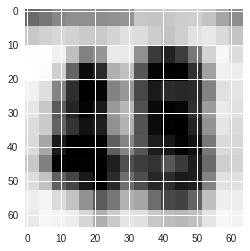

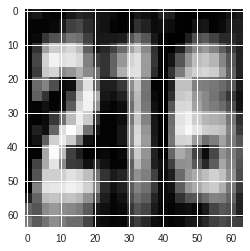

In [0]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))

Source: https://sajalsharma.com/portfolio/digit_sequence_recognition

## Export model

In [0]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K
import os.path as osp
from os import mkdir
from google.colab import files

prefix_output_node_names_of_final_network = 'output_node'

K.set_learning_phase(0)

pred = [None]*5
pred_node_names = [None]*5
for i in range(0, 5):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

sess = K.get_session()
output_fld = 'tensorflow_model/'
if not osp.isdir(output_fld):
    mkdir(output_fld)
output_graph_name = 'svhn_model' + '.pb'
output_graph_suffix = '_inference'

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))
files.download(osp.join(output_fld, output_graph_name))  # from colab to browser download

output nodes names are:  ['output_node0', 'output_node1', 'output_node2', 'output_node3', 'output_node4']
INFO:tensorflow:Froze 42 variables.
INFO:tensorflow:Converted 42 variables to const ops.
saved the constant graph (ready for inference) at:  tensorflow_model/svhn_model.pb
